In [1]:
import os
import pandas as pd
import datetime
import dateutil.parser
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imread

import helpers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

In [3]:
DOLLARS_PER_SCAN = 0.07

badgeMapping = {
    "blocker":"Aiden Ray",
    'Tiara': "probably valentine",
    'daniel':"Fred Holt",
    'Julia': "",
    'Zoheb':"NT",
    'betsabe':"",
    'simon':"",
    'Hugh':"Louise Villmunsen",
    'aron':"James Grose",
    'Yudie':"Louise Villmunsen",
    'rick':"Fred Holt",
    'arjun':"Louise Villmunsen",
    "alicia":"valentine",
    "taha":"Aiden Ray"
    
}

In [4]:
def getiOS_df(path):
    def mergeTimeDate(x):
        return dateutil.parser.parse(x[u' Date'] + " " + x[u' Time'])

    df = pd.DataFrame.from_dict( pd.read_csv(path,
                                             header=0) 
                               )
    df["timeStamp"] = df.apply(lambda x: mergeTimeDate(x), axis=1 )
    df = df.drop([u' Date',u' Time', u'Name'], 1)
    df.columns = ["stickerID","timeStamp"]
    return df 

def getAndroid_df(path):
    def convertTimeStamp(x):
        return dateutil.parser.parse(x["timeStamp"])
    df = pd.read_csv( path, 
                      header=None,
                      names=["stickerID","detectionType","xstickerID","timeStamp","xID"])
    df["tempTimeStamp"] = df.apply(lambda x: convertTimeStamp(x), axis=1 )
    df = df.drop(["xstickerID","detectionType","xID","timeStamp"], 1)
    df.columns = ["stickerID","timeStamp"]
    return pd.DataFrame.from_dict(df)

In [5]:
dirs = os.listdir(u'scan data')

allData = []
for d in dirs:
    path = u'scan data/'+d
    csvs = os.listdir(path)
    thisPersonsData = []
    for csv in csvs:
        tempdf = pd.DataFrame.from_dict( pd.read_csv(path+"/"+csv ,header=None))
        if tempdf.shape[1] > 4: #more than 4 means iPhone
            df = getAndroid_df(path+"/"+csv)
        else:
            df = getiOS_df(path+"/"+csv)
        df["person"] = d
        df["badge"]  = badgeMapping[d]
        df = df[df.stickerID<400]
        thisPersonsData.append( df )
        
    allthisPersonsData = pd.concat(thisPersonsData).drop_duplicates()
    if d == "Yudie":
        allthisPersonsData = allthisPersonsData[allthisPersonsData.timeStamp > datetime.datetime(2016, 11, 25, 16, 0)]
        print allthisPersonsData.shape
        
    allData.append({"data": allthisPersonsData, "name": d})

(1101, 4)


In [6]:
allUniqueDetections = pd.concat([x["data"] for x in allData])
print allUniqueDetections.shape #just checking that the numbers meet up different ways
allUniqueDetections.head(5)

(9833, 4)


,stickerID,timeStamp,person,badge
171,171,2016-11-25 10:10:07,Tiara,probably valentine
170,170,2016-11-25 10:06:15,Tiara,probably valentine
169,169,2016-11-25 10:06:08,Tiara,probably valentine
168,168,2016-11-25 10:06:00,Tiara,probably valentine
154,154,2016-11-25 10:05:49,Tiara,probably valentine


In [7]:
people = []
for p in allData:
    df = p["data"]
    timeWindowLength = (df.timeStamp.max()-df.timeStamp.min()).total_seconds()/60/60
    if timeWindowLength > 0:
        person = {}
        person["name"] = p["name"]
        person["detections"]  = df.shape[0]
        person["first"] = df.timeStamp.min()
        person["last"]  = df.timeStamp.max()
        person["time_spent"]  = timeWindowLength
        person["hourly_rate"] = (df.shape[0]*DOLLARS_PER_SCAN)/timeWindowLength
        person["owed"]        = df.shape[0]*DOLLARS_PER_SCAN
        person["total"]       = df.shape[0]*DOLLARS_PER_SCAN + 20
        
        people.append(person)
    else:
        print p["name"], "Zero length time period\n"


peopleDF = pd.DataFrame.from_dict(people).sort_values(by="hourly_rate",ascending=False)
print "Total detections:", peopleDF.detections.sum()
peopleDF

Total detections: 9833


,detections,first,hourly_rate,last,name,owed,time_spent,total
10,1345,2016-11-27 09:06:00,32.246218,2016-11-27 12:01:11,taha,94.15,2.919722,114.15
6,414,2016-11-27 09:45:41,31.405178,2016-11-27 10:41:03,rick,28.98,0.922778,48.98
5,603,2016-11-25 10:53:12,30.735437,2016-11-25 12:15:36,Zoheb,42.21,1.373333,62.21
2,1101,2016-11-25 16:00:04,29.718509,2016-11-25 18:35:40,Yudie,77.07,2.593333,97.07
3,1516,2016-11-25 13:20:34,29.198410,2016-11-25 16:58:38,Julia,106.12,3.634444,126.12
4,1079,2016-11-27 09:33:00,24.249353,2016-11-27 12:39:53,alicia,75.53,3.114722,95.53
12,562,2016-11-25 10:18:29,23.220856,2016-11-25 12:00:08,aron,39.34,1.694167,59.34
13,952,2016-11-27 10:04:41,23.085450,2016-11-27 12:57:53,arjun,66.64,2.886667,86.64
7,456,2016-11-24 18:30:31,22.089965,2016-11-24 19:57:13,betsabe,31.92,1.445000,51.92
0,220,2016-11-25 09:27:38,21.749706,2016-11-25 10:10:07,Tiara,15.40,0.708056,35.40


In [8]:
message = "".join([ "{name}:\n",
                    "Hi,\n",
                    "Thanks for coming in today, we took a big bite out of the target ",
                    "I've got you down as scanning {detections} stickers ",
                    "between {first} and {last} (that's {time_spent:.2f} hours).\n",
                    "I'm going to add $20 to cover getting you set up and that kind ",
                    "of thing, and to bump the per scan rate to $0.07, so that's ${owed} ",
                    "for scans, ${total} total that I owe you. If you're keeping track of ",
                    "this stuff, that's ${hourly_rate:.2f} an hour. (Just on scans.)\n",
                    "If you’d like to come back and do some more then it’d be great to have you. I’ve got to move house tomorrow, so I’m not going to be around, but Sunday and next week should be fine.\n",
                    "Ben\n"])
# for r in peopleDF.itertuples():
#         d = dict(r._asdict())
#         print message.format(**d)

In [9]:
everything = pd.concat([x["data"] for x in allData])
everything.stickerID = pd.to_numeric(everything.stickerID) 
everything.reset_index(drop=True, inplace=True)
everything.head(3)


,stickerID,timeStamp,person,badge
0,171,2016-11-25 10:10:07,Tiara,probably valentine
1,170,2016-11-25 10:06:15,Tiara,probably valentine
2,169,2016-11-25 10:06:08,Tiara,probably valentine


171 <type 'numpy.int64'>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f2980d290>]], dtype=object)

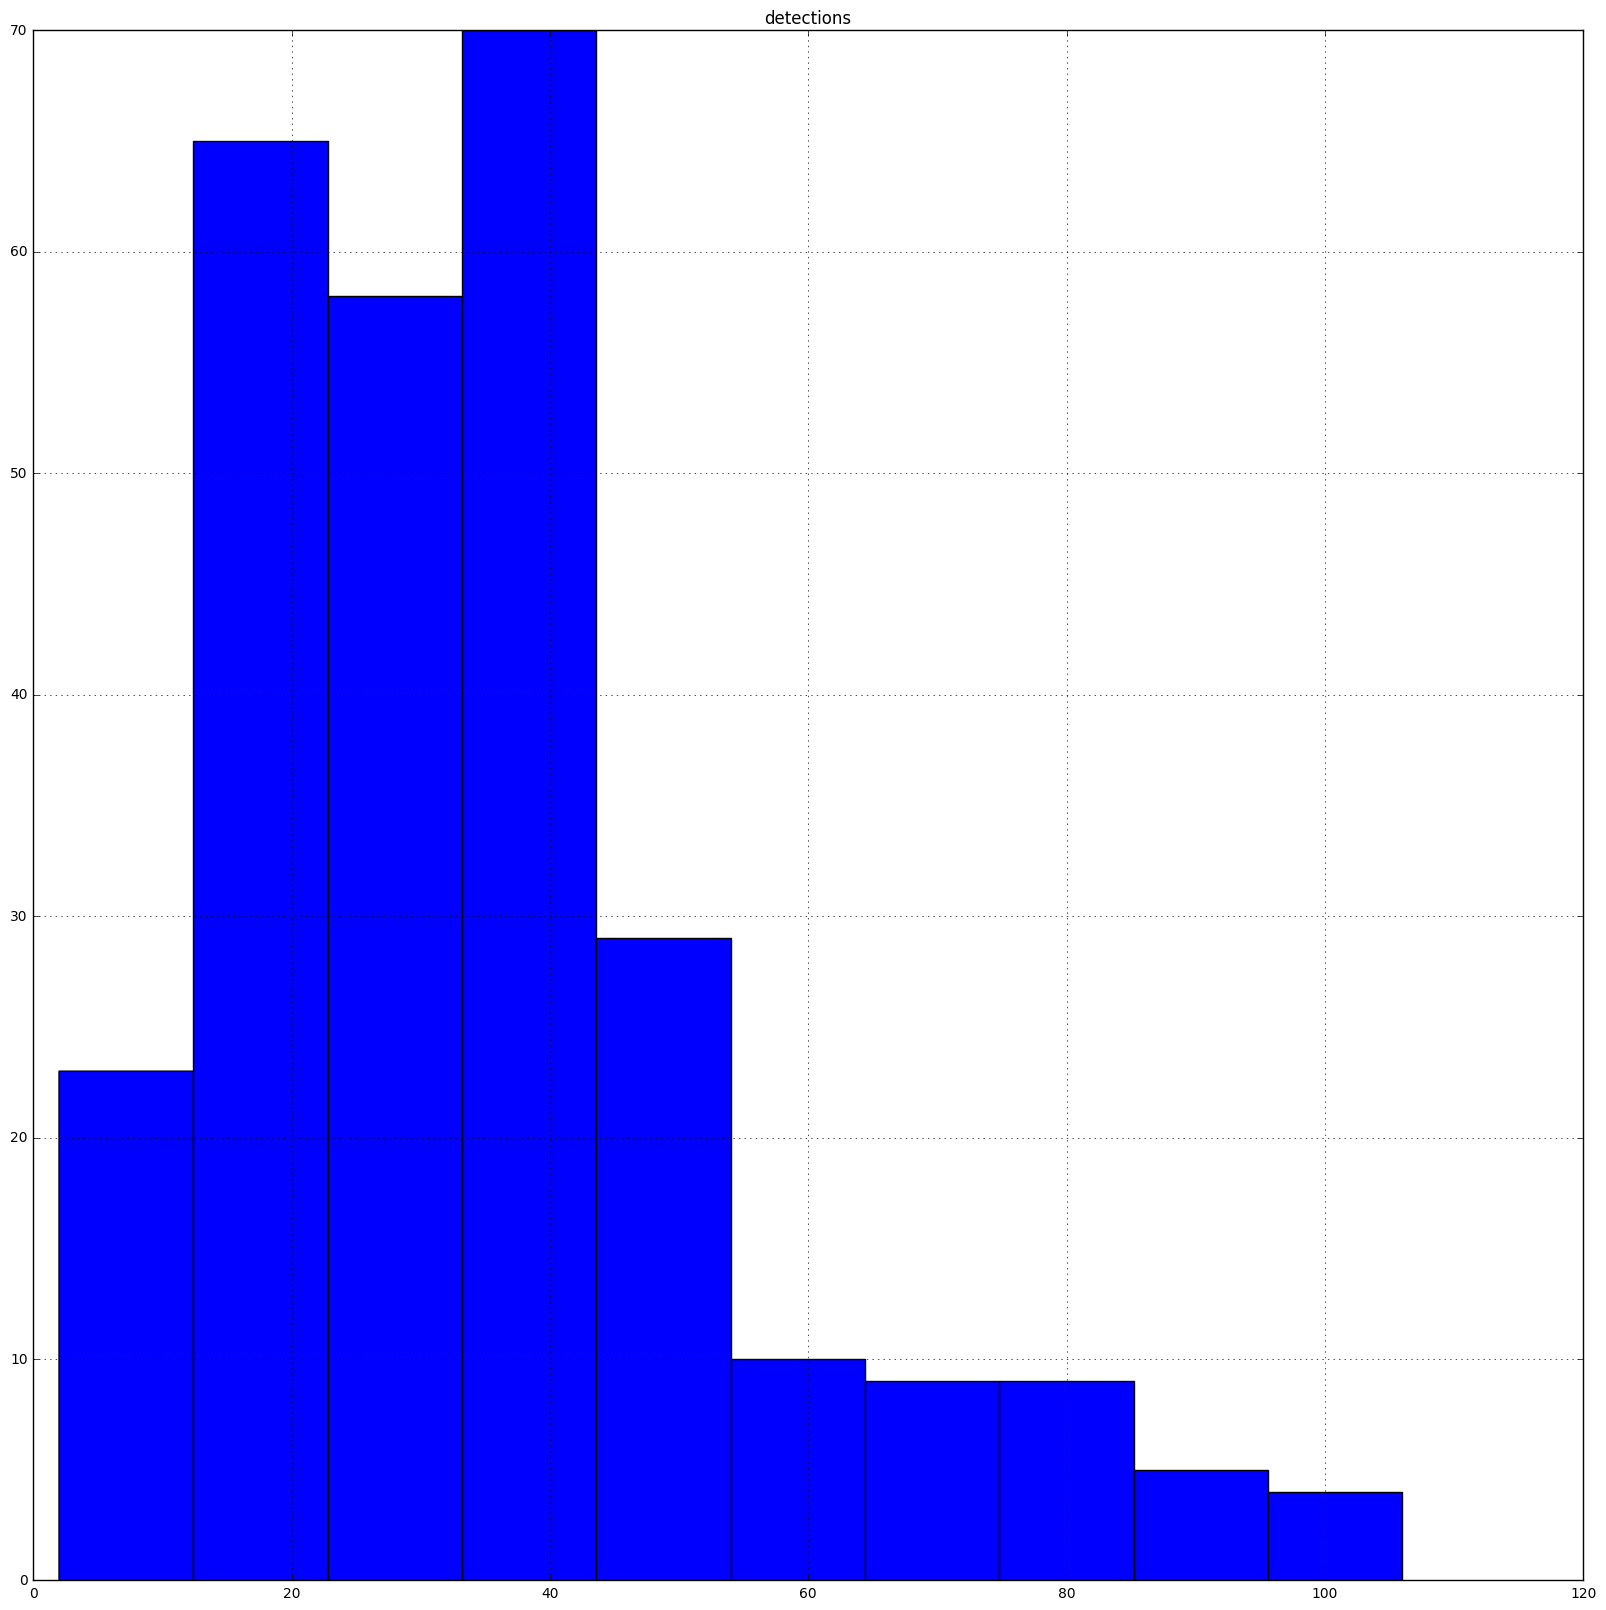

In [10]:
print everything.stickerID[0], type(everything.stickerID[0])
uniq = everything.stickerID.unique()
bins = {}
for u in uniq:
    bins[u] = []
    
scans = list(everything.stickerID)
for s in scans:
    bins[s].append(s)

for k in bins.keys():
    bins[k] = len(bins[k])
    
binDF = pd.DataFrame.from_dict(bins,orient='index')
binDF.columns = ["detections"]
binDF.hist()

In [11]:
binDF[binDF.detections<10]

,detections
63,9
72,7
73,4
93,4
101,5
112,4
130,8
166,3
167,4
180,9


In [12]:
stickerLocations = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/1sijQZR2iFLo2FS_3r5gbsuAkaglRz557LWjdLxnPkpE/pub?gid=0&single=true&output=csv")
stickerLocations = stickerLocations.drop(["z","raw"], 1) # this is just because we aren't on multiple floors
stickerLocations.head(3)

,stickerID,x,y
0,1,63852.09440,-13561.617780
1,2,62985.85359,-11830.460440
2,3,62985.85359,-9830.460444


In [13]:
baseStationData = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/167pxh_NRq5e9sQV9Zb8Z-Q-kdN7Zy9FCzCp47eVXTuE/pub?gid=1446311565&single=true&output=csv")
baseStationData = baseStationData.ix[:,0:5] #only keep the columns we care about
baseStationData = baseStationData.drop(["location"], 1)
baseStationData = baseStationData[baseStationData.agentId > 0] #not really sure how this works, maybe failure is falsy?
baseStationData.head(3)

,agentId,agentName,x,y
0,00000000e5bd0ae9,Ace,2953.206017,14427.458860
1,000000006c1a3b5a,Alfa,3323.405966,9086.502512
2,0000000020294bbd,Beer,3313.076869,2665.631392


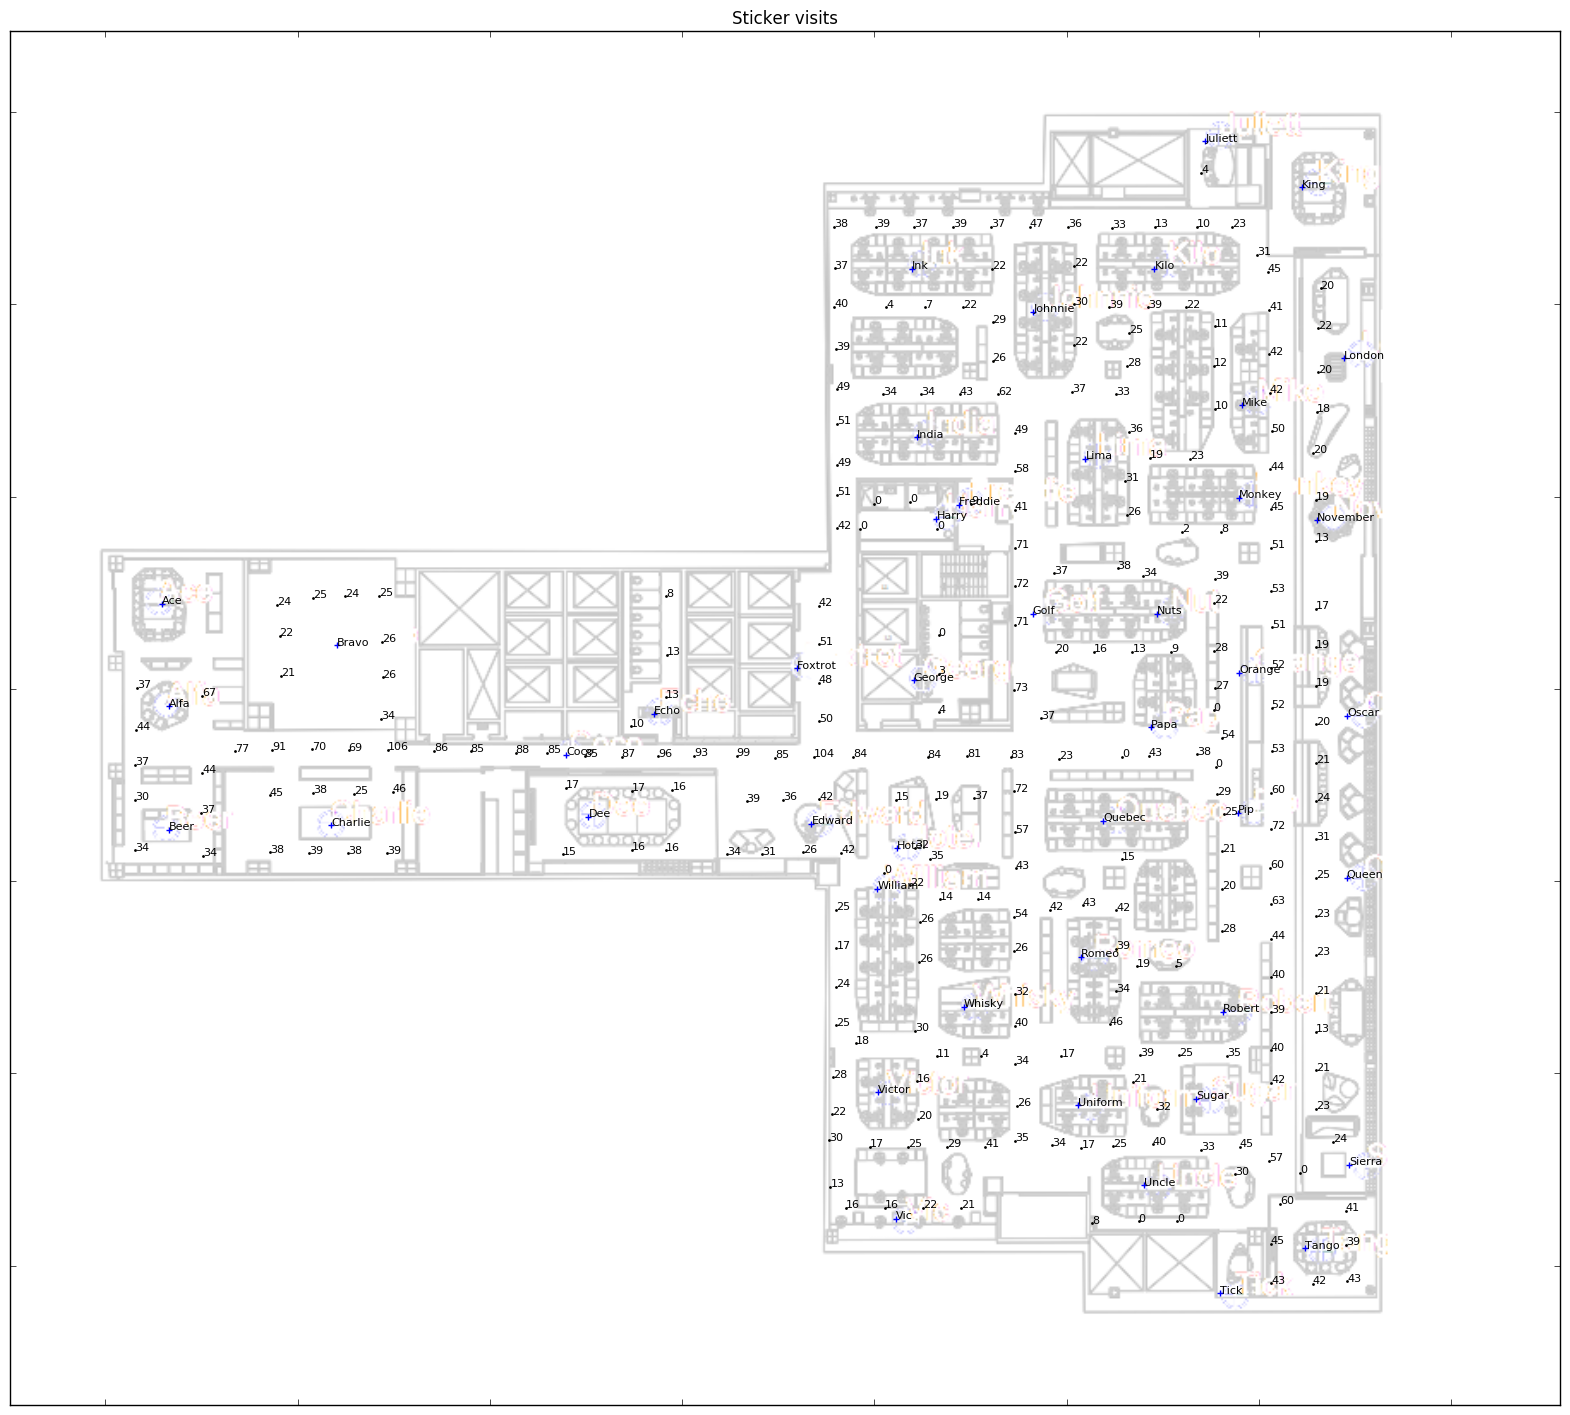

In [14]:
fig, ax = plt.subplots()

plt.title("Sticker visits")

#the sticker labels
for row in stickerLocations.iterrows():
    row = row[1] #BS indexing
    
    rowStickerID = int(row.stickerID)
    detectionCount = "duff"
    detectionCount = allUniqueDetections[allUniqueDetections.stickerID == rowStickerID].shape[0]
    label = "{1}".format(rowStickerID, detectionCount)
    ax.text(row.x, row.y, label, fontsize=8)

#sticker dots
ax.scatter(stickerLocations.x,stickerLocations.y,s=1,c="y")

#put the image on the graph as an underlay
img = imread("map.png")
ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
#                                [left,  right, bottom, top  ]

#put the baseStations on the map 
for index, row in baseStationData.iterrows():
    ax.text(row.x, row.y, row.agentName, fontsize=8)
ax.scatter(baseStationData.x,baseStationData.y, marker='+')

#Hide the axis numbers because they don't tell us much
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

fig.savefig("counts.pdf", bbox_inches='tight')

plt.show() #don't show, we need to save